**Задача**
- Найти набор данных для бинарной классификации рёбер в графе.
- Реализовать случайные блуждания алгоритма DeepWalk и построить множества схожих вершин
- Обучить эмбеддинги вершин, используя SGD и negative sampling.
- Визуализировать эмбеддинги.

 (+5 баллов) Также реализовать node2vec блуждания и обучить классификатор, используя его. Сравнить результаты.

# Dataset


Files:

nodeId.edges : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

nodeId.circles : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

nodeId.feat : The features for each of the nodes that appears in the edge file.

nodeId.egofeat : The features for the ego user.

nodeId.featnames : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
files_folder = '/content/drive/MyDrive/учеба/ИТМО/графы/2 курс/snap_facebook'


In [3]:
import os

facebook_tar_path = os.path.join(files_folder, 'facebook.tar.gz')
!tar -xvzf "$facebook_tar_path" -C /content/

facebook/
facebook/3980.egofeat
facebook/0.featnames
facebook/698.egofeat
facebook/3437.feat
facebook/3980.featnames
facebook/0.edges
facebook/3437.circles
facebook/686.circles
facebook/348.egofeat
facebook/107.feat
facebook/348.feat
facebook/1912.circles
facebook/3437.egofeat
facebook/698.feat
facebook/348.edges
facebook/1912.feat
facebook/414.circles
facebook/1684.egofeat
facebook/1684.featnames
facebook/1684.feat
facebook/107.egofeat
facebook/0.circles
facebook/414.edges
facebook/698.featnames
facebook/698.edges
facebook/1912.featnames
facebook/107.edges
facebook/107.circles
facebook/0.egofeat
facebook/414.featnames
facebook/3980.feat
facebook/3437.featnames
facebook/1912.egofeat
facebook/414.egofeat
facebook/698.circles
facebook/348.featnames
facebook/348.circles
facebook/0.feat
facebook/1684.circles
facebook/3437.edges
facebook/3980.edges
facebook/686.featnames
facebook/1912.edges
facebook/3980.circles
facebook/686.feat
facebook/1684.edges
facebook/414.feat
facebook/686.egofeat
fa

In [14]:
import pandas as pd
import networkx as nx
import os

edges_path = os.path.join('.', 'facebook_combined.txt.gz')
edges_df = pd.read_csv(edges_path, delimiter=' ', header=None, names=['node1', 'node2'])

# неориентированный граф
G = nx.from_pandas_edgelist(edges_df, 'node1', 'node2', create_using=nx.Graph())


In [15]:
edges_df.head(5)

,node1,node2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [16]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(4039, 88234)

# Реализовать случайные блуждания алгоритма DeepWalk и построить множества схожих вершин

In [17]:
embedding_dim = 128
learning_rate = 0.01
epochs = 10
num_walks = 10
walk_length = 40
num_neg_samples = len(G.edges())

import numpy as np
# Инициализация эмбеддингов для каждой вершины
node_embeddings = {node: np.random.rand(embedding_dim) for node in G.nodes()}

In [18]:
import random

def random_walk(graph, start_node, walk_length):
    """
    Функция для создания случайного пути фиксированной длины
    return: walk - список всех случайных блужданий

    """
    walk = [start_node]
    for _ in range(walk_length - 1):
        neighbors = list(graph.neighbors(walk[-1]))
        if len(neighbors) > 0:
            walk.append(random.choice(neighbors))
        else:
            break
    return walk


walks = []
for node in G.nodes():
    for _ in range(num_walks):
        walks.append(random_walk(G, node, walk_length))

In [19]:
window_size = 5

# Функция для генерации пар "центр-контекст" из случайного блуждания
def generate_pairs_from_walk(walk, window_size):
    pairs = []
    for i, center_node in enumerate(walk):
        for j in range(max(0, i - window_size), min(len(walk), i + window_size + 1)):
            if i != j:
                context_node = walk[j]
                pairs.append((center_node, context_node))
    return pairs

# Генерируем все пары "центр-контекст" из случайных блужданий
training_pairs = []
for walk in walks:
    training_pairs.extend(generate_pairs_from_walk(walk, window_size))

# Обучить эмбеддинги вершин, используя SGD и negative sampling

In [20]:
# Функция для сэмплирования негативных рёбер
def sample_negative_edges(G, num_neg_samples):
    neg_edge_list = []
    pos_set = set(G.edges())
    while len(neg_edge_list) < num_neg_samples:
        u, v = np.random.choice(list(G.nodes()), 2)
        if u != v and (u, v) not in pos_set and (v, u) not in pos_set:
            neg_edge_list.append((u, v))
    return neg_edge_list


In [21]:
# Функция сигмоиды для расчета вероятности
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Функция для вероятности рёбра
def edge_probability(u, v, embeddings):
    return sigmoid(np.dot(embeddings[u], embeddings[v]))

# Функция для обновления эмбеддингов
def update_embeddings(u, v, label, embeddings, learning_rate):
    prob = edge_probability(u, v, embeddings)
    gradient = (label - prob) * embeddings[v]  # Градиент для u
    embeddings[u] += learning_rate * gradient  # Обновление для u

    gradient = (label - prob) * embeddings[u]  # Градиент для v
    embeddings[v] += learning_rate * gradient  # Обновление для v

In [22]:
# Обучение эмбеддингов с использованием пар из случайных блужданий
for epoch in range(epochs):
    for u, v in training_pairs:
        update_embeddings(u, v, label=1, embeddings=node_embeddings, learning_rate=learning_rate)

    # Негативные примеры для каждой пары
    neg_edges = sample_negative_edges(G, num_neg_samples)
    for u, v in neg_edges:
        update_embeddings(u, v, label=0, embeddings=node_embeddings, learning_rate=learning_rate)

    print(f"Epoch {epoch + 1} completed")

Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed


# Визуализировать эмбеддинги.

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Получение эмбеддингов узлов
node_list = list(node_embeddings.keys())
embedding_matrix = np.array([node_embeddings[node] for node in node_list])

# Снижение размерности с помощью t-SNE
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(embedding_matrix)



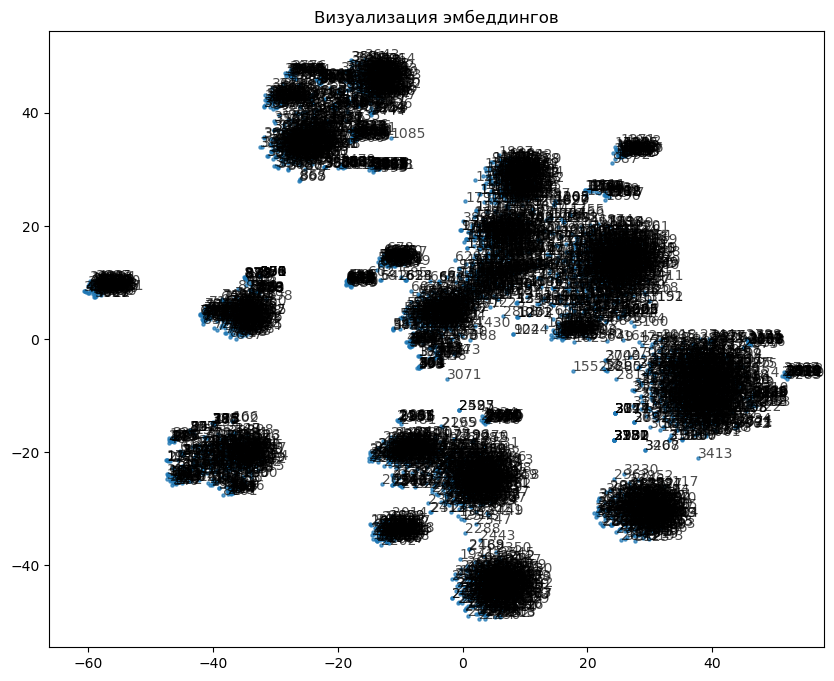

In [24]:

plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], s=5, alpha=0.7)

# Добавляем метки узлов
for i, node in enumerate(node_list):
    plt.annotate(str(node), (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]), alpha=0.7)

plt.title("Визуализация эмбеддингов")
plt.show()

# Классификатор

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


In [26]:
# Получение позитивных и негативных рёбер
positive_edges = list(G.edges())
negative_edges = sample_negative_edges(G, len(positive_edges))

In [27]:

# Функция для создания признаков
def get_edge_features(u, v, embeddings):
    emb_u = embeddings[u]
    emb_v = embeddings[v]
    return np.concatenate([emb_u, emb_v])

In [28]:
X = np.array([get_edge_features(u, v, node_embeddings) for u, v in positive_edges + negative_edges])
y = np.array([1] * len(positive_edges) + [0] * len(negative_edges))


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [29]:
# Обучение модели логистической регрессии
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [30]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.75
F1 Score: 0.75


# (+5 баллов) Также реализовать node2vec блуждания и обучить классификатор, используя его. Сравнить результаты.

In [31]:
import numpy as np
import random

# Node2Vec parameters
p = 1  # Параметр "возвращения"
q = 1  # Параметр "исследования"


def node2vec_walk(graph, start_node, walk_length, p, q):
    walk = [start_node]
    for _ in range(walk_length - 1):
        current_node = walk[-1]
        neighbors = list(graph.neighbors(current_node))
        if len(neighbors) > 0:
            if len(walk) == 1:
                # Для первого шага случайно выбираем следующий узел
                walk.append(random.choice(neighbors))
            else:
                # Для остальных шагов учитываем параметры p и q
                prev_node = walk[-2]
                probabilities = []
                for neighbor in neighbors:
                    if neighbor == prev_node:
                        probabilities.append(1 / p)
                    elif graph.has_edge(prev_node, neighbor):
                        probabilities.append(1)
                    else:
                        probabilities.append(1 / q)
                probabilities = np.array(probabilities) / sum(probabilities)
                next_node = np.random.choice(neighbors, p=probabilities)
                walk.append(next_node)
        else:
            break
    return walk

# Создание Node2Vec блужданий
node2vec_walks = []
for node in G.nodes():
    for _ in range(num_walks):
        node2vec_walks.append(node2vec_walk(G, node, walk_length, p, q))


In [32]:
window_size = 5
node2vec_pairs = []
for walk in node2vec_walks:
    node2vec_pairs.extend(generate_pairs_from_walk(walk, window_size))

# Инициализация Node2Vec эмбеддингов
node2vec_embeddings = {node: np.random.rand(embedding_dim) for node in G.nodes()}

# Обучение Node2Vec эмбеддингов
for epoch in range(epochs):
    for u, v in node2vec_pairs:
        update_embeddings(u, v, label=1, embeddings=node2vec_embeddings, learning_rate=learning_rate)

    # Обучение на негативных примерах
    neg_edges = sample_negative_edges(G, num_neg_samples)
    for u, v in neg_edges:
        update_embeddings(u, v, label=0, embeddings=node2vec_embeddings, learning_rate=learning_rate)

    print(f"Эпоха {epoch + 1} для Node2Vec embeddings")


Эпоха 1 для Node2Vec embeddings
Эпоха 2 для Node2Vec embeddings
Эпоха 3 для Node2Vec embeddings
Эпоха 4 для Node2Vec embeddings
Эпоха 5 для Node2Vec embeddings
Эпоха 6 для Node2Vec embeddings
Эпоха 7 для Node2Vec embeddings
Эпоха 8 для Node2Vec embeddings
Эпоха 9 для Node2Vec embeddings
Эпоха 10 для Node2Vec embeddings


In [33]:
# Подготовка признаков для классификации рёбер с Node2Vec эмбеддингами
X_node2vec = np.array([get_edge_features(u, v, node2vec_embeddings) for u, v in positive_edges + negative_edges])
y_node2vec = np.array([1] * len(positive_edges) + [0] * len(negative_edges))

# Разделение данных
X_train_node2vec, X_test_node2vec, y_train_node2vec, y_test_node2vec = train_test_split(X_node2vec, y_node2vec, test_size=0.3, random_state=42)

# Обучение логистической регрессии на Node2Vec эмбеддингах
classifier_node2vec = LogisticRegression(max_iter=1000, random_state=42)
classifier_node2vec.fit(X_train_node2vec, y_train_node2vec)

# Оценка модели
y_pred_node2vec = classifier_node2vec.predict(X_test_node2vec)
accuracy_node2vec = accuracy_score(y_test_node2vec, y_pred_node2vec)
f1_node2vec = f1_score(y_test_node2vec, y_pred_node2vec)

print(f"Accuracy Node2vec: {accuracy_node2vec:.2f}")
print(f"F1 Node2vec: {f1_node2vec:.2f}")

Accuracy Node2vec: 0.75
F1 Node2vec: 0.75


In [34]:
print("\n--- Сравнение результатов ---")
print(f"DeepWalk Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")
print(f"Node2Vec Accuracy: {accuracy_node2vec:.2f}, F1 Score: {f1_node2vec:.2f}")



--- Сравнение результатов ---
DeepWalk Accuracy: 0.75, F1 Score: 0.75
Node2Vec Accuracy: 0.75, F1 Score: 0.75


# Вывод

Подходы показали одинаковую результативность